In [1]:
import torch
import torch.nn as nn
from torchinfo import summary

SEED = 10

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [2]:
from sklearn.datasets import fetch_openml

df, target = fetch_openml("mnist_784", return_X_y=True)
print(f"Shape X: {df.shape}")
print(f"Shape y: {target.shape}")

Shape X: (70000, 784)
Shape y: (70000,)


In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    df, target, test_size=0.25, random_state=SEED
)

In [4]:
from torch.utils.data import DataLoader, Dataset


class MNIST(Dataset):

    def __init__(self, X, y):

        self.X = X.to_numpy()
        self.y = y.values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return dict(
            X=torch.tensor(self.X[idx], dtype=torch.float32)
            .view(28, 28)
            .unsqueeze(0),
            y=torch.tensor(int(self.y[idx]), dtype=torch.long),
        )


train_set = MNIST(X_train, y_train)
test_set = MNIST(X_test, y_test)

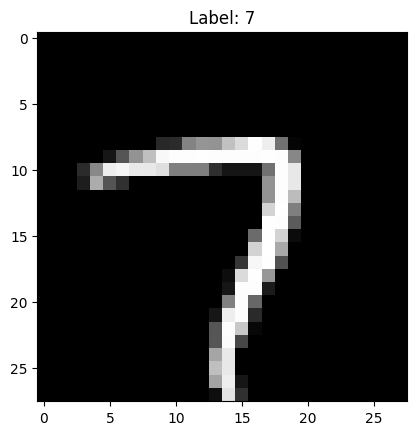

In [5]:
def plot_number(X, y, tensor=True):

    if tensor:
        X = X.numpy().squeeze(0)
        y = y.item()

    plt.imshow(X, cmap="gray")
    plt.title(f"Label: {y:.0f}")
    plt.show()


idx = torch.randint(0, len(train_set), (1,)).item()
plot_number(train_set[idx]["X"], train_set[idx]["y"])

In [6]:
train_set[0]["X"].shape, train_set[0]["y"].shape

(torch.Size([1, 28, 28]), torch.Size([]))

In [7]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, n_outputs=10, ks=3):
        super().__init__()
        self.conv1 = self.CNN_block(in_channels, 64, k=ks)
        self.conv2 = self.CNN_block(64, 32, k=ks)
        self.flatten = nn.Flatten()
        # self.fc1 = nn.LazyLinear(32)
        self.fc1 = nn.Linear(32 * 5 * 5, 16)  # filtros x tamaño
        self.fc2 = nn.Linear(16, n_outputs)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

    @staticmethod
    def CNN_block(c_in, c_out, k=3, p=0, s=1, pk=2, ps=2):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=c_in,
                out_channels=c_out,
                kernel_size=k,
                padding=p,
                stride=s,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pk, stride=ps),
        )


model = CNN(in_channels=1, n_outputs=10)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 13, 13]           --
│    └─Conv2d: 2-1                       [1, 64, 26, 26]           640
│    └─ReLU: 2-2                         [1, 64, 26, 26]           --
│    └─MaxPool2d: 2-3                    [1, 64, 13, 13]           --
├─Sequential: 1-2                        [1, 32, 5, 5]             --
│    └─Conv2d: 2-4                       [1, 32, 11, 11]           18,464
│    └─ReLU: 2-5                         [1, 32, 11, 11]           --
│    └─MaxPool2d: 2-6                    [1, 32, 5, 5]             --
├─Flatten: 1-3                           [1, 800]                  --
├─Linear: 1-4                            [1, 16]                   12,816
├─Linear: 1-5                            [1, 10]                   170
Total params: 32,090
Trainable params: 32,090
Non-trainable params: 0
Total

In [8]:
import torchmetrics
import numpy as np
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training in {device}")
model = CNN(in_channels=1, n_outputs=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

EPOCHS = 100

train_dataloader = DataLoader(
    train_set,
    batch_size=1024,
    shuffle=True,
    pin_memory=True,
    num_workers=10,
    drop_last=True,
)
test_dataloader = DataLoader(
    test_set, batch_size=32, shuffle=False, pin_memory=True, num_workers=10
)

train_metric = torchmetrics.Recall(task="multiclass", num_classes=10).to(
    device
)
test_metric = torchmetrics.Recall(task="multiclass", num_classes=10).to(
    device
)
train_losses = []
test_losses = []

for e in range(EPOCHS):
    start_time = time.time()
    train_batch_losses = []
    test_batch_losses = []
    for batch in train_dataloader:
        X, y = batch["X"].to(device), batch["y"].to(device)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        tm = train_metric(y_pred, y)
        train_batch_losses.append(loss.item())

    tm = train_metric.compute()
    train_epoch_loss = np.mean(train_batch_losses)

    with torch.no_grad():
        for batch in test_dataloader:
            X, y = batch["X"].to(device), batch["y"].to(device)
            y_pred = model(X)
            loss = criterion(y_pred, y)
            tst_m = test_metric(y_pred, y)
            test_batch_losses.append(loss.item())
    tst_m = test_metric.compute()
    test_epoch_loss = np.mean(test_batch_losses)
    end_time = time.time()

    train_losses.append(train_epoch_loss)
    test_losses.append(test_epoch_loss)

    epoch_time = end_time - start_time
    ## Logging
    print(
        f"Epoch: {e+1}- time: {epoch_time:.2f} - Train Loss: {train_epoch_loss:.4f} - Test Loss: {test_epoch_loss:.4f}- Train Recall: {tm:.4f} - Test Recall: {tst_m:.4f}"
    )

Training in cuda
Epoch: 0- time: 2.61 - Train Loss: 2.2997 - Test Loss: 0.5438- Train Recall: 0.5871 - Test Recall: 0.8500
Epoch: 1- time: 2.42 - Train Loss: 0.3812 - Test Loss: 0.2982- Train Recall: 0.7392 - Test Recall: 0.8828
Epoch: 2- time: 2.36 - Train Loss: 0.2428 - Test Loss: 0.2133- Train Recall: 0.8029 - Test Recall: 0.9012
Epoch: 3- time: 2.38 - Train Loss: 0.1837 - Test Loss: 0.1690- Train Recall: 0.8386 - Test Recall: 0.9129
Epoch: 4- time: 2.35 - Train Loss: 0.1494 - Test Loss: 0.1438- Train Recall: 0.8620 - Test Recall: 0.9216
Epoch: 5- time: 2.37 - Train Loss: 0.1264 - Test Loss: 0.1268- Train Recall: 0.8788 - Test Recall: 0.9283
Epoch: 6- time: 2.36 - Train Loss: 0.1122 - Test Loss: 0.1174- Train Recall: 0.8912 - Test Recall: 0.9337
Epoch: 7- time: 2.38 - Train Loss: 0.0984 - Test Loss: 0.1093- Train Recall: 0.9011 - Test Recall: 0.9379
Epoch: 8- time: 2.34 - Train Loss: 0.0883 - Test Loss: 0.0962- Train Recall: 0.9091 - Test Recall: 0.9415
Epoch: 9- time: 2.39 - Train 

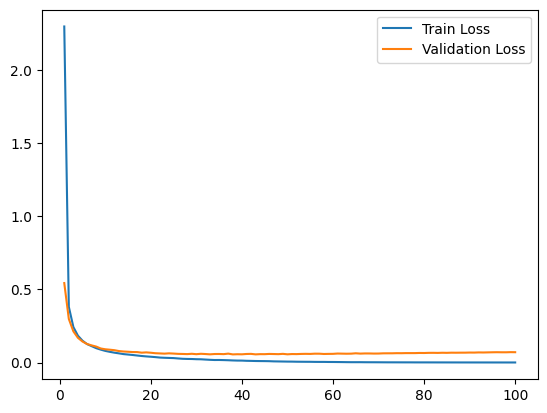

In [9]:
def plot_training_curves(train_loss, validation_loss, n_epochs, title=""):
    plt.plot(
        range(1, n_epochs + 1),
        train_loss,
        label="Train Loss",
    )
    plt.plot(
        range(1, n_epochs + 1),
        validation_loss,
        label="Validation Loss",
    )
    plt.title(title)
    plt.legend()
    plt.show()


plot_training_curves(train_losses, test_losses, EPOCHS)